Домашнее задание №2 выполнили Алина Плетминцева, Влада Моргунова, Анна Маркина, Элина Галиева, Анастасия Денисова

В нашем домашнем задании мы использовали метод коллаборативной фильтрации, которая позволила нам построить модель предсказания рейтинга фильмов. Коллаборативная фильтрация - это процесс фильтрации или оценки предметов с использованием мнений других людей. Коллаборативная фильтрация не требует ничего, кроме истории предпочтений пользователей в отношении набора элементов. Поскольку метод основан на исторических данных, основное предположение здесь заключается в том, что пользователи, которые согласились в прошлом, также склонны соглашаться в будущем.

Источник: Schafer, Ben & J, Ben & Frankowski, Dan & Dan, & Herlocker, & Jon, & Shilad, & Sen, Shilad. (2007). Collaborative Filtering Recommender Systems. 

Решить данную задачу можно через нахождение сходства между пользователями по предуыдущим оценкам, а также через нахождение сходства между фильмами. Мы рассмотрим оба варианта.

Для начала импортируем нужные нам библиотеки и подгружаем данные, с помощью которых мы будем строить строить прогноз

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity 
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.preprocessing import MinMaxScaler
from numpy import *
import matplotlib.pyplot as plt
%matplotlib inline
import wordcloud
from wordcloud import WordCloud, STOPWORDS

In [3]:
movies = pd.read_csv('movies.csv',index_col=False)
ratings= pd.read_csv('ratings.csv')

Посмотрим на наши данные по фильмам с помощью облака слов

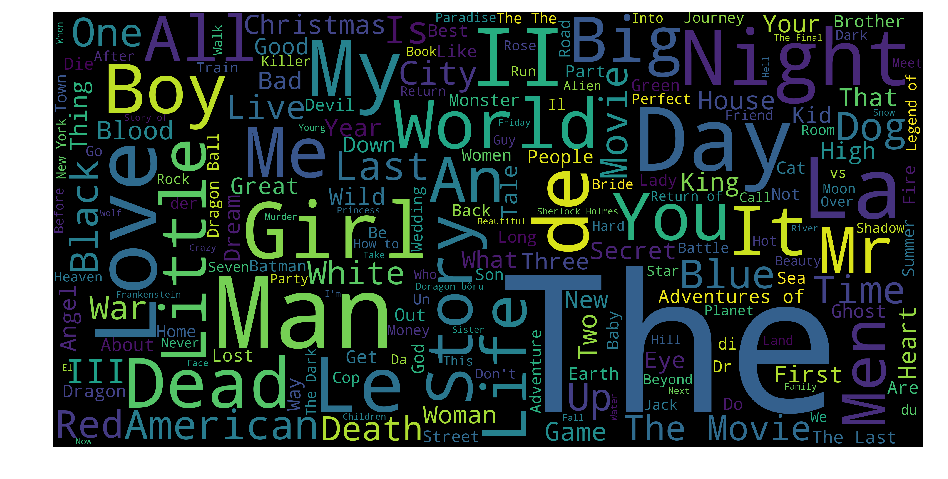

In [104]:
movies['title'] = movies['title'].fillna("").astype('str')
title_corpus = ' '.join(movies['title'])
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='black', height=2000, width=4000).generate(title_corpus)

plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

Наиболее часто встречающимися словами в названиях фильмов, помимо артикля The, стали Day, Man и Night. Обратимся теперь к данным по рейтингу фильмов и посмотрим на распределение оценок.

In [105]:
ratings['rating'].describe()

count    100836.000000
mean          3.501557
std           1.042529
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

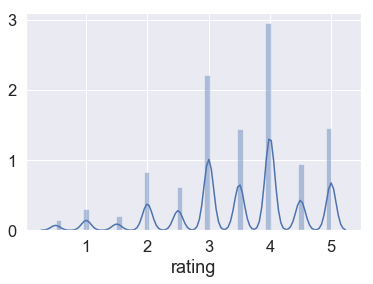

In [106]:
import seaborn as sns
sns.set_style('darkgrid')
sns.set(font_scale=1.5)
%matplotlib inline
sns.distplot(ratings['rating'].fillna(ratings['rating'].median()))

Чаще всего пользователи оценивали фильмы на 4 по 5-балльной шкале. Соединим теперь данные по рейтингу и оценке фильмов в единую таблицу, дропнув не нужные нам для построения модели столбцы

In [8]:
movie_ratings = movies.merge(ratings,on = 'movieId',how = 'inner')
movie_ratings = movie_ratings.drop(['title', 'genres', 'timestamp'], axis=1)
movie_ratings.head()

,movieId,userId,rating
0,1,1,4.0
1,1,5,4.0
2,1,7,4.5
3,1,15,2.5
4,1,17,4.5


In [9]:
print(movie_ratings.shape)

(100836, 3)


В отношении 3:7 разделим данные на трейн и тест и выведем объем получившихся выборок

In [10]:
from sklearn.model_selection import train_test_split
train_ratings, test_ratings  = train_test_split(movie_ratings, test_size = 0.3)
print(train_ratings.shape)
print(test_ratings.shape)

(70585, 3)
(30251, 3)


Сделаем дамми для выборок трейн и тест. Для этого зададим значения 0 и 1 в зависимости от следующих условий:

dum_tr (для предсказания оценки): 
0 - уже оцененные пользователем фильмы
1 - неоцененные фильмы 

dum_test(для оценки предсказания):
0 - неоцененные фильмы 
1 - уже оцененные пользователем фильмы

In [11]:
dum_tr=train_ratings.copy()
dum_test =test_ratings.copy()
dum_tr['rating'] = dum_tr['rating'].apply(lambda x: 0 if x>=1 else 1)
dum_test['rating'] = dum_test['rating'].apply(lambda x: 1 if x>=1 else 0)
dum_tr = dum_tr.pivot(columns='movieId', values='rating', index='userId').fillna(1)
dum_test = dum_test.pivot(columns='movieId', values='rating', index='userId').fillna(0)

## 1. User-User Based Similarity

Как известно, пользователи ставят оценки не всем фильмам. Составим сводную sparse-таблицу, где зададим рейтинг в качестве значений, userId - строк, а movieId -  столбцов. Недостающие оценки (NaN) мы можем заполнить как 0, среднюю оценку пользователя по всем оцененным фильмам или как среднюю оценку по фильму, поставлнную другими пользователями. Рассмотрим в данной работе опцию использования среднего значения для фильмов, оцененных пользователем

In [12]:
movie_ratings_pivot = train_ratings.pivot(columns = 'movieId',values = 'rating', index = 'userId' )
movie_ratings_pivot.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Нормализуем рейтинг для каждого пользователя

In [13]:
mean = np.nanmean(movie_ratings_pivot, axis=1)
movie_ratings_pivot = (movie_ratings_pivot.T-mean).T
movie_ratings_pivot.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,-0.373563,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Перейдем к построению матрицы сходства пользователей (user similarity matrix) Для этого мы будем использовать косинусное сходство и посмотрим, насколько похожи пользователи. Косинусное сходство рассчитывается из рейтинга фильма, который разные пользователи оценили в прошлом.

In [113]:
user_similar_corr =  1 - pairwise_distances(movie_ratings_pivot.fillna(0), metric ='cosine')
user_similar_corr[np.isnan(user_similar_corr)]=0
print(user_similar_corr)

[[1.         0.03836696 0.         ... 0.21256919 0.05392514 0.08223358]
 [0.03836696 1.         0.         ... 0.02130378 0.         0.05464321]
 [0.         0.         1.         ... 0.01685713 0.         0.03997844]
 ...
 [0.21256919 0.02130378 0.01685713 ... 1.         0.05727532 0.1997841 ]
 [0.05392514 0.         0.         ... 0.05727532 1.         0.0582869 ]
 [0.08223358 0.05464321 0.03997844 ... 0.1997841  0.0582869  1.        ]]


Для предсказания оценок фильма нам необходимо рассмотреть только пользователей, которые положительно коррелируют (то есть положительно связаны) друг с другом. "Непохожих" друг на друга юзеров (корреляция которых отрицательна) мы игнорируем

In [114]:
user_similar_corr[user_similar_corr<0]=0

Рейтинг, прогнозируемый для каждого пользователя (на фильмы как с уже известным рейтингом, так и  без него), представляет собой взвешенную сумму корреляции с рейтингом фильма (который уже известен нам из датасета).

In [115]:
movie_rating_pivot = train_ratings.pivot(index='userId', columns = 'movieId', values = 'rating')
movie_rating_pivot.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,190219,190221,191005,193565,193571,193573,193581,193583,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [116]:
predict_rating_byuser = np.dot(user_similar_corr, movie_rating_pivot.fillna(0))
print(predict_rating_byuser)

[[7.81785478e+01 2.88098067e+01 2.01260395e+01 ... 2.80007117e-02
  2.80007117e-02 2.54871283e-01]
 [2.35998883e+01 9.41504088e+00 3.35767686e+00 ... 4.02025379e-01
  4.02025379e-01 4.29515358e-01]
 [3.52088536e+00 1.15155235e+00 1.28332382e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [9.27107688e+01 3.76751543e+01 2.02761869e+01 ... 4.63798138e-02
  4.63798138e-02 7.43583701e-01]
 [6.74723839e+01 2.93927552e+01 1.51222324e+01 ... 0.00000000e+00
  0.00000000e+00 1.09861326e-01]
 [6.57897097e+01 2.79976589e+01 1.16296469e+01 ... 3.12320292e-01
  3.12320292e-01 8.36055215e-01]]


Перемножим предсказанный рейтинг фильма на дамми трейн выборки, где значение 0 соотвутствует уже оцененным пользователем фильмам, а 1 - неоцененным. Таким образом, предсказанные значения оценок фильма будут присвоены только тем фильмам, рейтинг которых у конкретного пользователя ранее был неизвестен, а значения уже оценных фильмов будут приравнены к 0

In [117]:
finalpredict_rating_byuser = np.multiply(predict_rating_byuser, dum_tr)
finalpredict_rating_byuser.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,190219,190221,191005,193565,193571,193573,193581,193583,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,0.000000,28.809807,0.000000,0.943423,11.765749,0.000000,11.712843,1.688030,3.380791,42.031008,...,0.071341,0.071341,0.036001,0.028001,0.032001,0.032001,0.032001,0.028001,0.028001,0.254871
2,23.599888,9.415041,3.357677,0.318937,2.422907,11.514602,2.307378,0.579647,0.745703,10.699900,...,0.049884,0.049884,0.516890,0.402025,0.459458,0.459458,0.459458,0.402025,0.402025,0.429515
3,3.520885,1.151552,1.283324,0.000000,0.550562,3.589088,0.728371,0.065305,0.195657,2.741307,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,46.959942,16.871810,9.206789,0.518571,7.126277,25.044085,7.247185,0.854816,1.479050,23.393117,...,0.033172,0.033172,0.026784,0.020832,0.023808,0.023808,0.023808,0.020832,0.020832,0.291442
5,0.000000,29.179587,14.975603,2.169707,14.928220,31.094534,16.884664,2.854615,2.606721,43.031479,...,0.152519,0.152519,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.186038


Для иллюстрации прогноза выведем топ 10 фильмов для пользователя с userId = 100

In [118]:
finalpredict_rating_byuser.iloc[10].sort_values(ascending=False)[0:10]

movieId
296     94.059461
593     84.319024
457     78.343110
527     72.616281
2571    67.352339
47      65.695285
260     63.942472
50      63.538079
1       62.389438
592     61.961145
Name: 11, dtype: float64

## 2. Item-Item Based Similarity

Аналогично корреляции пользователей друг с другом на основе предыдыщих оценок, мы можем вычислить корреляцию фильмов между собой. В предыдущем варианте мы брали среднее значение оценки фильма для каждого пользователя. Теперь мы рассмторим второй вариант и транспонируем sparse матрицу, чтобы нормализовать рейтинг вокруг среднего значения для различных фильмов.

In [119]:
movie_rating_pivotT = train_ratings.pivot(index='userId', columns = 'movieId', values = 'rating').T
movie_rating_pivotT.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,...,4.0,NaN,4.0,3.0,4.0,2.5,4.0,2.5,3.0,NaN
2,NaN,NaN,NaN,NaN,NaN,4.0,NaN,4.0,NaN,NaN,...,NaN,4.0,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN
3,4.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN


In [121]:
mean = np.nanmean(movie_rating_pivotT, axis=1)
movie_rating_pivotT = (movie_rating_pivotT.T-mean).T
movie_rating_pivotT.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.101974,NaN,NaN,NaN,0.101974,NaN,NaN,NaN,NaN,NaN,...,0.101974,NaN,0.101974,-0.898026,0.101974,-1.398026,0.101974,-1.398026,-0.898026,NaN
2,NaN,NaN,NaN,NaN,NaN,0.623188,NaN,0.623188,NaN,NaN,...,NaN,0.623188,NaN,1.623188,NaN,NaN,NaN,NaN,NaN,NaN
3,0.710526,NaN,NaN,NaN,NaN,1.710526,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,0.600000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,1.948718,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-0.051282,NaN,NaN,NaN,NaN,NaN,NaN


In [122]:
from sklearn.metrics.pairwise import pairwise_distances
item_similar_corr = 1 - pairwise_distances(movie_rating_pivotT.fillna(0), metric='cosine')
item_similar_corr[np.isnan(item_similar_corr)] = 0
print(item_similar_corr)

[[1.         0.11417444 0.07321093 ... 0.         0.         0.        ]
 [0.11417444 1.         0.05994883 ... 0.         0.         0.        ]
 [0.07321093 0.05994883 1.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 1.         0.         0.        ]
 [0.         0.         0.         ... 0.         1.         0.        ]
 [0.         0.         0.         ... 0.         0.         1.        ]]


Аналогично, как и в user based similarity, мы заинтересованы только в схожих фильмах (которые вызывают похожую реакцию пользователей) 

In [123]:
item_similar_corr[item_similar_corr<0]=0
item_similar_corr

array([[1.        , 0.11417444, 0.07321093, ..., 0.        , 0.        ,
        0.        ],
       [0.11417444, 1.        , 0.05994883, ..., 0.        , 0.        ,
        0.        ],
       [0.07321093, 0.05994883, 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

In [124]:
predict_rating_byitem = np.dot((movie_rating_pivotT.fillna(0).T),item_similar_corr)
predict_rating_byitem

array([[ 4.36084941e+00,  5.33657503e+00,  1.13958201e+01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.76388043e-01, -8.15112166e-03, -1.35617015e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-6.95309685e-01, -8.14955028e-01, -1.11045684e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [-1.44309049e+01, -2.44730401e+00, -1.01574803e+01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.06044513e+00, -7.48293690e-01, -6.39027425e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 9.38854405e+00,  9.95508235e+00,  1.01205420e+01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

In [125]:
finalpredict_rating_byitem = np.multiply(predict_rating_byitem,dum_tr)
finalpredict_rating_byitem.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,190219,190221,191005,193565,193571,193573,193581,193583,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,0.000000,5.336575,0.000000,0.520480,4.575851,0.000000,2.885416,2.408721,4.167995,6.244531,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.176388,-0.008151,-0.135617,-0.135341,0.241026,-0.030328,0.029034,0.116723,0.031405,-0.075744,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.695310,-0.814955,-1.110457,0.000000,-0.009844,0.019432,-0.503413,-0.141478,-0.581644,-0.221353,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-1.098529,-0.761642,-0.902511,-0.283329,0.757877,-1.041853,-0.844532,-0.135168,-0.215534,-0.586615,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.000000,-0.097294,-0.025213,-0.489630,0.701155,-0.053696,0.465105,0.267629,-0.127579,-0.325062,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [127]:
finalpredict_rating_byitem.iloc[1].sort_values(ascending=False)[0:5]

movieId
4068      0.919081
135137    0.859350
140715    0.816247
87867     0.792591
72167     0.766518
Name: 2, dtype: float64

## Оценка 

Для начала оценим первую рассмотренную нами модель, User-User Based Similarity

In [128]:
test_movie_ratings_pivot = test_ratings.pivot(
    index='userId',
    columns='movieId',
    values='rating')

In [129]:
mean = np.nanmean(test_movie_ratings_pivot, axis=1)
test_pivotT = (test_movie_ratings_pivot.T-mean).T

test_user_corr = 1 - pairwise_distances(test_pivotT.fillna(0), metric='cosine')
test_user_corr[np.isnan(test_user_correlation)] = 0
print(test_user_corr)

[[ 1.          0.          0.         ... -0.00272452 -0.03694802
   0.00518086]
 [ 0.          1.          0.         ...  0.          0.
  -0.01686793]
 [ 0.          0.          1.         ...  0.          0.
   0.00209101]
 ...
 [-0.00272452  0.          0.         ...  1.         -0.00609123
   0.01629662]
 [-0.03694802  0.          0.         ... -0.00609123  1.
   0.        ]
 [ 0.00518086 -0.01686793  0.00209101 ...  0.01629662  0.
   1.        ]]


In [130]:
test_user_corr[test_user_corr<0]=0
test_user_predict = np.dot(test_user_corr, test_movie_ratings_pivot.fillna(0))
test_user_predict

array([[1.64858281e+00, 7.99396358e-01, 1.86763351e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.03330550e-01, 4.89719695e-01, 1.08185936e-02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [9.95034103e-01, 6.32161224e-01, 1.30705237e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [4.12779514e+00, 5.13477612e+00, 2.86081185e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [5.94029043e+00, 4.70216455e+00, 5.69474990e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.12622232e+01, 3.48331569e+00, 8.32164392e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [131]:
test_user_final = np.multiply(test_user_predict, dum_test)
test_user_final.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,185135,187031,187541,187593,187595,190209,190215,193567,193579,193585
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [132]:
X  = test_user_final.copy() 
X = X[X>0]

In [133]:
scaler = MinMaxScaler(feature_range=(3, 4))
print(scaler.fit(X))

MinMaxScaler(copy=True, feature_range=(3, 4))


/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:364: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:365: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


In [134]:
y = (scaler.transform(X))
print(y)

[[       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]
 ...
 [       nan 3.10376502 3.40047027 ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]
 [3.37167936        nan        nan ...        nan        nan        nan]]


In [135]:
test1 = test_ratings.pivot(
    index='userId',
    columns='movieId',
    values='rating')

total_number_non_nan = np.count_nonzero(~np.isnan(y))

In [136]:
mse1 = (sum(sum((test1 - y)**2))/total_number_non_nan)
print(mse1)

0.7012277971820879


## Item based

In [139]:
test_movie_ratings_pivotT = test_ratings.pivot(columns='movieId', values='rating', index='userId').T
mean = np.nanmean(test_movie_ratings_pivotT, axis=1)
test_pivotT = (test_movie_ratings_pivotT.T-mean).T

In [140]:
test_item_corr = 1 - pairwise_distances(test_pivotT.fillna(0), metric='cosine')
test_item_corr[np.isnan(test_item_corr)] = 0
test_item_corr[test_item_corr<0]=0

In [142]:
test_item_predict = (np.dot(test_item_corr, test_movie_ratings_pivotT.fillna(0))).T
test_item_final = np.multiply(test_item_predict,dum_test)
test_item_final.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,185135,187031,187541,187593,187595,190209,190215,193567,193579,193585
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [155]:
X  = test_item_final.copy() 
X = X[X>0]

total_number_non_nan = np.count_nonzero(~np.isnan(y))

In [156]:
scaler = MinMaxScaler(feature_range=(3, 4))
print(scaler.fit(X))

MinMaxScaler(copy=True, feature_range=(3, 4))


/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:364: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:365: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


In [157]:
y = (scaler.transform(X))
print(y)

[[       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]
 ...
 [       nan 3.28982171 3.62747762 ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]
 [3.78935988        nan        nan ...        nan        nan        nan]]


In [158]:
test2 = test_ratings.pivot(
    index='userId',
    columns='movieId',
    values='rating'
)

In [159]:
mse2  = (sum(sum((test2 - y )**2))/total_number_non_nan)
print(mse2)

1.1394998928817939


Вывод: 
Метрика качества, которую мы использовали для оценки, показала результат лучше для модели с user-based similarity по сравнению с item based similarity, mse которой превышает 1. Наилучший показатель MSE, которого нам удалось добиться равен 0.7012